## Data Wrangling

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# import sample data to 'df' variable
df = pd.read_csv('../raw_data/ski_resort_data.csv')

A good starting approach is as follows:

### 1. Call `df.info()` and `df.head()` to get an overview of the data.

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               330 non-null    object 
 1   Region             330 non-null    object 
 2   state              330 non-null    object 
 3   summit_elev        330 non-null    int64  
 4   vertical_drop      330 non-null    int64  
 5   base_elev          330 non-null    int64  
 6   trams              330 non-null    int64  
 7   fastEight          164 non-null    float64
 8   fastSixes          330 non-null    int64  
 9   fastQuads          330 non-null    int64  
 10  quad               330 non-null    int64  
 11  triple             330 non-null    int64  
 12  double             330 non-null    int64  
 13  surface            330 non-null    int64  
 14  total_chairs       330 non-null    int64  
 15  Runs               326 non-null    float64
 16  TerrainParks       279 non

### 2. Verify data integrity and check missing values with the following:

In [29]:
# Creating lists of missing data by count and percentage
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', 'percentage']
missing.sort_values(by='count', ascending = False).head(13)

,count,percentage
fastEight,166,50.303030
NightSkiing_ac,143,43.333333
AdultWeekday,54,16.363636
AdultWeekend,51,15.454545
daysOpenLastYear,51,15.454545
TerrainParks,51,15.454545
projectedDaysOpen,47,14.242424
Snow Making_ac,46,13.939394
averageSnowfall,14,4.242424
LongestRun_mi,5,1.515152


Note that sometimes missing data values are encoded with -1, 999, 0, or some value that does not make sense in the context of the column.

Features can be numeric (e.g. `AdultWeekday` and `fastEight` columns), categorical (e.g. `region`), or even both (e.g. month).

### 3. Check for row values that shouldn't be duplicated.  In this case, while we have a ski resort that is duplicated, they refer to different ski resorts.

We see there are 2 Crystal Mountains with the following code:

In [33]:
df['Name'].value_counts().head()

Crystal Mountain    2
Alyeska Resort      1
Brandywine          1
Boston Mills        1
Alpine Valley       1
Name: Name, dtype: int64

We can explore this further, where the notebook suggests the following code to individually check vs 'Region' and vs 'State:

In [ ]:
(ski_data['Name'] + ', ' + ski_data['Region']).value_counts().head()
(ski_data['Name'] + ', ' + ski_data['state']).value_counts().head()

I prefer to look at that particular tuple:

In [34]:
df[df['Name']=='Crystal Mountain']

,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastEight,fastSixes,fastQuads,...,LongestRun_mi,SkiableTerrain_ac,Snow Making_ac,daysOpenLastYear,yearsOpen,averageSnowfall,AdultWeekday,AdultWeekend,projectedDaysOpen,NightSkiing_ac
104,Crystal Mountain,Michigan,Michigan,1132,375,757,0,0.0,0,1,...,0.3,102.0,96.0,120.0,63.0,132.0,54.0,64.0,135.0,56.0
295,Crystal Mountain,Washington,Washington,7012,3100,4400,1,NaN,2,2,...,2.5,2600.0,10.0,NaN,57.0,486.0,99.0,99.0,NaN,NaN


In [45]:
df[df.state == 'Montana'].set_index('Name').T

Name,Big Sky Resort,Blacktail Mountain Ski Area,Bridger Bowl,Discovery Ski Area,Great Divide,Lost Trail - Powder Mtn,Maverick Mountain,Montana Snowbowl,Red Lodge Mountain,Showdown Montana,Teton Pass Ski Resort,Big Mountain Resort
Region,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana
state,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana,Montana
summit_elev,11166,6676,8700,8150,7330,8200,8520,7600,9416,8200,7200,6817
vertical_drop,4350,1440,2600,2380,1580,1800,2020,2600,2400,1400,1010,2353
base_elev,7500,5236,6100,5770,5750,6400,6500,5000,7016,6800,6190,4464
trams,1,0,0,0,0,0,0,0,0,0,0,0
fastEight,1.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0
fastSixes,2,0,0,0,0,0,0,0,0,0,0,0
fastQuads,5,0,0,0,0,0,0,0,2,0,0,3
quad,3,0,1,0,0,0,0,0,0,0,0,2


### 4.  Check each column variable for extremes and possibly manually correct if necessary.

In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
summit_elev,330.0,4591.818182,3735.535934,315.0,1403.75,3127.5,7806.00,13487.0
vertical_drop,330.0,1215.427273,947.864557,60.0,461.25,964.5,1800.00,4425.0
base_elev,330.0,3374.000000,3117.121621,70.0,869.00,1561.5,6325.25,10800.0
trams,330.0,0.172727,0.559946,0.0,0.00,0.0,0.00,4.0
fastEight,164.0,0.006098,0.078087,0.0,0.00,0.0,0.00,1.0
fastSixes,330.0,0.184848,0.651685,0.0,0.00,0.0,0.00,6.0
fastQuads,330.0,1.018182,2.198294,0.0,0.00,0.0,1.00,15.0
quad,330.0,0.933333,1.312245,0.0,0.00,0.0,1.00,8.0
triple,330.0,1.500000,1.619130,0.0,0.00,1.0,2.00,8.0
double,330.0,1.833333,1.815028,0.0,1.00,1.0,3.00,14.0


Getting a visual representation of each variable:

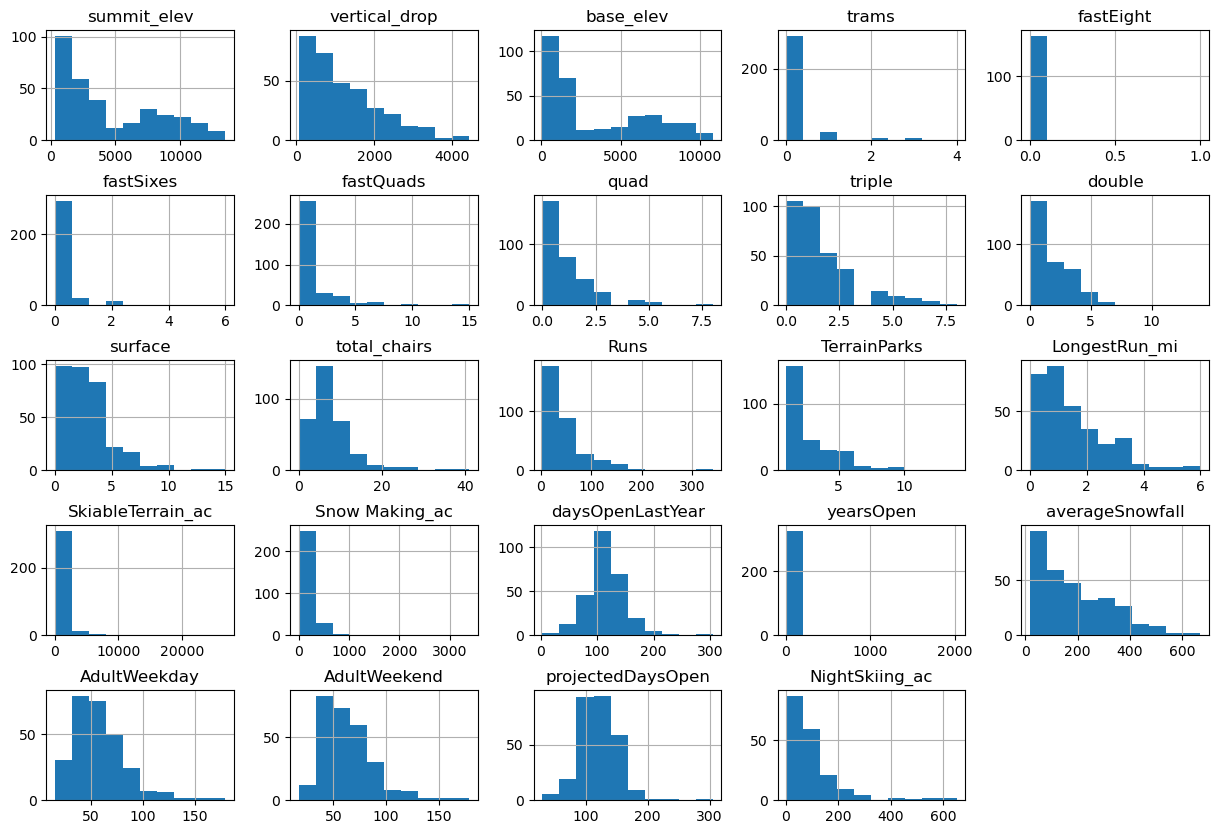

In [51]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

There are numerous issues with the data:
1. `summit_elev` - too many values clustered near 0
2. `vertical_drop` - too many values clustered near 0
3. `trams` - too many values clustered near 0
4. `fastEight` - too many values clustered near 0
5. `fastSixes` - too many values clustered near 0
6. `total_chairs` - higher data points seems a bit unreasonable
7. `runs` - higher data points seems a bit unreasonable
8. `SkiableTerrain_ac` - too many values clustered near 0 and the max value seems absurdly high
9. `Snow Making_ac` - too many values clustered near 0 and the max value seems absurdly high
10. `yearsOpen` - too many values clustered near 0 and the max value seems absurdly high 

Looking at  `SkiableTerrain_ac`:

In [56]:
df[df.SkiableTerrain_ac > 10000].T

,39
Name,Silverton Mountain
Region,Colorado
state,Colorado
summit_elev,13487
vertical_drop,3087
base_elev,10400
trams,0
fastEight,0.0
fastSixes,0
fastQuads,0


A quick search shows that the actual number should be 1819.

In [61]:
df.loc[39, 'SkiableTerrain_ac'] = 1819
df.loc[39, 'SkiableTerrain_ac']

1819.0

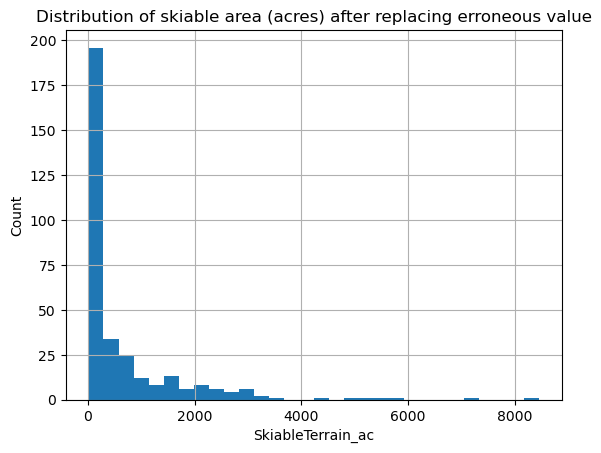

In [63]:
df.SkiableTerrain_ac.hist(bins=30)
plt.xlabel('SkiableTerrain_ac')
plt.ylabel('Count')
plt.title('Distribution of skiable area (acres) after replacing erroneous value');

In [64]:
df[df.SkiableTerrain_ac > 6000].T

,266,267
Name,Park City,Powder Mountain
Region,Salt Lake City,Utah
state,Utah,Utah
summit_elev,10000,9422
vertical_drop,3200,2522
base_elev,6800,6900
trams,4,0
fastEight,0.0,0.0
fastSixes,6,0
fastQuads,10,1


Upon search, it appears these values are legitimate.

In [65]:
df[df.yearsOpen>1000]

,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastEight,fastSixes,fastQuads,...,LongestRun_mi,SkiableTerrain_ac,Snow Making_ac,daysOpenLastYear,yearsOpen,averageSnowfall,AdultWeekday,AdultWeekend,projectedDaysOpen,NightSkiing_ac
115,Pine Knob Ski Resort,Michigan,Michigan,1308,300,1009,0,0.0,0,0,...,1.0,80.0,80.0,NaN,2019.0,NaN,49.0,57.0,NaN,NaN


## Example of named Aggregations

In [66]:
state_summary = df.groupby('state').agg(
    resorts_per_state=pd.NamedAgg(column='Name', aggfunc='size'), #could pick any column here
    state_total_skiable_area_ac=pd.NamedAgg(column='SkiableTerrain_ac', aggfunc='sum'),
    state_total_days_open=pd.NamedAgg(column='daysOpenLastYear', aggfunc='sum'),
    state_total_terrain_parks=pd.NamedAgg(column='TerrainParks', aggfunc='sum'),
    state_total_nightskiing_ac=pd.NamedAgg(column='NightSkiing_ac', aggfunc='sum')
).reset_index()
state_summary.head()

,state,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrain_parks,state_total_nightskiing_ac
0,Alaska,3,2280.0,345.0,4.0,580.0
1,Arizona,2,1577.0,237.0,6.0,80.0
2,California,21,25948.0,2738.0,81.0,587.0
3,Colorado,22,43682.0,3258.0,74.0,428.0
4,Connecticut,5,358.0,353.0,10.0,256.0
